In [1]:
import sys
sys.path.insert(1, '../scripts')

In [3]:
# data processing
import pandas as pd
from Bio import AlignIO
import alignment_quality as aq
import crutil

# logistic regression model
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

# plotting
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams.update({'font.size': 14})
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = "Arial"

## Colors
cscheme = {'pos':'#0177BB', 'neg':'#CB3627', 'dis':'#828282', 'helix':'#009988', 'sheet':'#EE7733', 'cr':'#AA4499',
          'null':"black"}

In [4]:
import warnings
warnings.filterwarnings('ignore')

In [5]:
states = ['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L',
          'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y']

## Functions

In [6]:
def get_aa_freq(seq, aa):
    cnt = 0
    for i in seq:
        if i == aa:
            cnt += 1
    aa_freq = cnt / len(seq)
    return aa_freq

In [7]:
def append_percent_aa(row, aa):
    seq = row['region_seq']
    if len(seq) == 0:
        print(row['uni_id'])
    return get_aa_freq(seq, aa)

## Training logistic regression model using AlphaFold data

In [8]:
df = pd.read_csv('../../data/af_regions/sc_af_regions_all.csv')

In [9]:
for aa in states:
    df['freq_'+aa] = df.apply(lambda row: append_percent_aa(row, aa), axis=1)

In [10]:
featurecol = []
for aa in states:
    featurecol.append('freq_'+aa)
X = df[featurecol]
y = df['label']
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)
logreg = LogisticRegression()
logreg.fit(X, y)

LogisticRegression()

## Conservation of labels in highly charged regions

In [11]:
df_hc = pd.read_csv('../../data/charged_regions/cr_filtered_aflabel.csv')

In [12]:
fdir = '/mnt/d/research/drummond-lab/data/aybrah-all/'
wrong_seq = []
for index, row in df_hc.iterrows():
    orf = row['orf']
    msa = AlignIO.read(open(fdir+str(orf)+'-aybrah.fa'), "fasta")
    contains_seq = False
    for record in msa:
        seq = crutil.remove_gaps(record.seq)
        if row['region.seq'] in seq:
            contains_seq = True
    if not contains_seq:
        wrong_seq.append(index)

In [13]:
df_hc.drop(df_hc.index[wrong_seq], inplace=True)

In [14]:
def append_percent_aa(row, aa):
    seq = row['seq']
    return get_aa_freq(seq, aa)

In [15]:
def append_structure_conservation(row):
    fdir = '/mnt/d/research/drummond-lab/data/aybrah-all/'
    orf = row['orf']  
    refseq = row['region.seq']
    left_bound = row['left.bound']
    right_bound = row['right.bound']
    sc_label = row['label']
    
    msa = AlignIO.read(open(fdir+str(orf)+'-aybrah.fa'), "fasta")
    if len(msa) >= 15:
        region_msa = aq.extract_region_msa(msa, left_bound, right_bound, refseq=refseq)
        tmpdf = pd.DataFrame(columns=['seq'])
        for seq in region_msa:
            s = crutil.remove_gaps(seq.seq)
            name = seq.id
            if len(s) >= 30:
                tmpdf = tmpdf.append({'seq': s}, ignore_index=True)
        if len(tmpdf) >= 15:
            for aa in states:
                tmpdf['freq_'+aa] = tmpdf.apply(lambda r: append_percent_aa(r, aa), axis=1)
            featurecol = []
            for aa in states:
                featurecol.append('freq_'+aa)
            X = tmpdf[featurecol]
            y = logreg.predict(X).tolist()
            d_cons = y.count('disordered') / len(y)
            h_cons = y.count('helix') / len(y)
            if d_cons > h_cons:
                return d_cons
            else:
                return -h_cons
    else:
        return None

In [16]:
df_hc['cons'] = df_hc.apply(lambda row: append_structure_conservation(row), axis=1)

In [17]:
len(df_hc[df_hc.cons >= 0.8]) / len(df_hc)

0.45977011494252873

## Conservation of secondary structure in randomly selected regions

In [18]:
df_random = pd.read_csv('../../data/af_regions/random_af_regions_low_thresh.csv')

In [19]:
with open('../../data/misc/uniprot-to-sgdid.txt') as f:
    mappings = {}
    for line in f:
        uniprot = line[95:106].rstrip()
        orf = line[75:95].rstrip()
        mappings[uniprot] = orf

In [20]:
fdir = '/mnt/d/research/drummond-lab/data/aybrah-all/'
bad_seq = []
for index, row in df_random.iterrows():
    orf = mappings[row['uni_id']]
    try:
        msa = AlignIO.read(open(fdir+str(orf)+'-aybrah.fa'), "fasta")
        contains_seq = False
        for record in msa:
            seq = crutil.remove_gaps(record.seq)
            if row['seq'] in seq:
                contains_seq = True
        if not contains_seq:
            bad_seq.append(index)
    except:
        bad_seq.append(index)

In [21]:
df_random.drop(df_random.index[bad_seq], inplace=True)

In [22]:
def append_structure_conservation2(row):
    fdir = '/mnt/d/research/drummond-lab/data/aybrah-all/'
    orf = mappings[row['uni_id']]
    refseq = row['seq']
    left_bound = row['left_bound']
    right_bound = row['right_bound']
    sc_label = row['label']
    msa = AlignIO.read(open(fdir+str(orf)+'-aybrah.fa'), "fasta")
    if len(msa) >= 15:
        region_msa = aq.extract_region_msa(msa, left_bound, right_bound, refseq=refseq)
        tmpdf = pd.DataFrame(columns=['seq'])
        for seq in region_msa:
            s = crutil.remove_gaps(seq.seq)
            name = seq.id
            if len(s) >= 30:
                tmpdf = tmpdf.append({'seq': s}, ignore_index=True)
        if len(tmpdf) >= 15:
            for aa in states:
                tmpdf['freq_'+aa] = tmpdf.apply(lambda r: append_percent_aa(r, aa), axis=1)
            featurecol = []
            for aa in states:
                featurecol.append('freq_'+aa)
            X = tmpdf[featurecol]
            y = logreg.predict(X).tolist()
            d_cons = y.count('disordered') / len(y)
            h_cons = y.count('helix') / len(y)
            if d_cons > h_cons:
                return d_cons
            else:
                return -h_cons
    else:
        return None

In [23]:
df_random['cons'] = df_random.apply(lambda row: append_structure_conservation2(row), axis=1)

## Summary plot

In [24]:
def append_dominant_label(row):
    if row['cons'] > 0:
        return 'disordered'
    elif row['cons'] < 0:
        return 'helix'
    else:
        return 'no_conservation'

In [25]:
df_hc['main_label'] = df_hc.apply(lambda row:append_dominant_label(row), axis=1)

In [26]:
df_random['main_label'] = df_random.apply(lambda row:append_dominant_label(row), axis=1)

In [27]:
df_hc['abs_cons'] = df_hc['cons'].abs()
df_random['abs_cons'] = df_random['cons'].abs()

In [28]:
df_hc_matched = df_hc[df_hc.cons >= 0]
df_random_matched = df_random[df_random.cons >= 0]

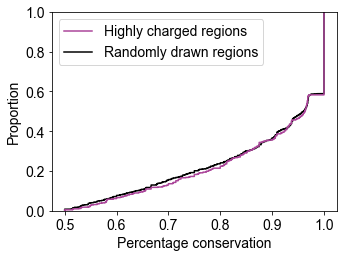

In [45]:
plt.figure(figsize=(5,3.8))
bw = 0.5
sns.ecdfplot(data=df_hc, x='abs_cons', color='#AA4499', zorder=2)
sns.ecdfplot(data=df_random, x='abs_cons', color='black', zorder=1)
plt.legend(['Highly charged regions',
            'Randomly drawn regions'])
plt.xlabel('Percentage conservation')
plt.tight_layout()
plt.savefig('../../figures/plots/Figure3.4F.png', dpi=300)
plt.show()

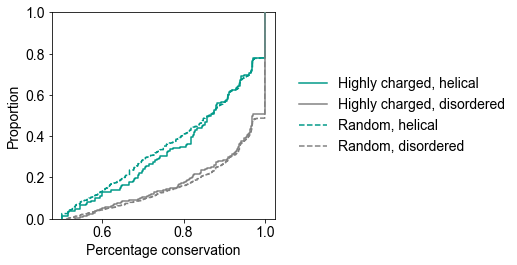

In [34]:
plt.figure(figsize=(4,3.8))
bw = 0.5
sns.ecdfplot(data=df_hc[df_hc.main_label == 'helix'], x='abs_cons',
             color=cscheme['helix'], zorder=3,
             label='Highly charged, helical')
sns.ecdfplot(data=df_hc[df_hc.main_label == 'disordered'], x='abs_cons',
             color=cscheme['dis'], zorder=4,
             label='Highly charged, disordered')
sns.ecdfplot(data=df_random[df_random.main_label == 'helix'], x='abs_cons',
             color=cscheme['helix'], linestyle='--', zorder=1,
             label='Random, helical')
sns.ecdfplot(data=df_random[df_random.main_label == 'disordered'], x='abs_cons',
             color=cscheme['dis'], linestyle='--', zorder=2,
             label='Random, disordered')
plt.legend(bbox_to_anchor=(1.05, 0.75),
           frameon=False)
plt.xlabel('Percentage conservation')
plt.tight_layout()
#plt.savefig('../../figures/plots/Figure3.4F.png', dpi=300)
plt.show()

## Spot checking outliers

In [35]:
def prediction_viewer(orf, left_bound):
    fdir = '/mnt/d/research/drummond-lab/data/aybrah-all/'
    row = df_hc[(df_hc.orf == orf) & (df_hc['left.bound'] == left_bound)].iloc[0]
    orf = row['orf']  
    refseq = row['region.seq']
    left_bound = row['left.bound']
    right_bound = row['right.bound']
    sc_label = row['label']

    msa = AlignIO.read(open(fdir+str(orf)+'-aybrah.fa'), "fasta")
    region_msa = aq.extract_region_msa(msa, left_bound, right_bound, refseq=refseq)

    tmpdf = pd.DataFrame(columns=['seq'])
    for seq in region_msa:
        s = crutil.remove_gaps(seq.seq)
        if len(s) >= 30:
            tmpdf = tmpdf.append({'seq': s}, ignore_index=True)

    for aa in states:
        tmpdf['freq_'+aa] = tmpdf.apply(lambda r: append_percent_aa(r, aa), axis=1)
    featurecol = []
    for aa in states:
        featurecol.append('freq_'+aa)
    X = tmpdf[featurecol]
    y = logreg.predict(X).tolist()
    for index,row in tmpdf.iterrows():
        print(row['seq'], y[index])    

In [38]:
df_hc[(df_hc.main_label == 'helix')].sort_values(by='abs_cons').head(10)

,orf,gene,seq.len,left.bound,right.bound,region.seq,region.len,charge.asymmetry,frac.charge,kappa1,kappa2,uni_id,orf_label,label,cons,main_label,abs_cons
682,YOR086C,TCB1,1187,791,856,VLTLEEIQDLDKVNKKKKALELRKSAIDEKKISKEDKAKFDQEWNE...,66,0.001894,0.484848,0.097280,0.214663,Q12466,verified,helix,-0.500000,helix,0.500000
73,YDL058W,USO1,1791,1074,1140,NKISELTKTREELEAELAAYKNLKNELETKLETSEKALKEVKENEE...,67,0.012037,0.462687,0.038101,0.090771,P25386,verified,disordered,-0.500000,helix,0.500000
384,YJL109C,UTP10,1770,1137,1186,EFINKITEETDQDYYDVRRNLRLKVYSVLLDETSDKKLIRNIREEF...,50,0.004000,0.400000,0.108860,0.322665,P42945,verified,helix,-0.515152,helix,0.515152
205,YER164W,CHD1,1469,1040,1102,LPVKSFEKYGETYDEMMEAAKDCVHEEEKNRKEILEKLEKHATAYR...,63,0.002268,0.444444,0.058872,0.145417,P32657,verified,helix,-0.515152,helix,0.515152
769,YPR133C,SPN1,411,118,169,ATPSSRQELEEKLDRILKKPKVRRTRRDEDDLEQYLDEKILRLKDE...,52,0.000000,0.500000,0.140362,0.302989,Q06505,verified,helix,-0.516129,helix,0.516129
655,YNR007C,ATG3,311,238,287,VMKILLDKVRVVRQRRRKELQEEQELDGVGDWEDLQDDIDDSLRVD...,50,0.021739,0.460000,0.173253,0.440934,P40344,verified,helix,-0.517241,helix,0.517241
325,YHR088W,RPF1,296,6,58,INITNKLKRQEIFADIKHEKNKERHTMRRKRAKEERENPELREQRL...,53,0.026125,0.490566,0.075383,0.176116,P38805,verified,helix,-0.531250,helix,0.531250
505,YLR309C,IMH1,912,128,180,SASSETLKDKEEEFLKKEQNYKNDIDDLKKKMEALNIELDTVQKEK...,53,0.012579,0.452830,0.041063,0.103084,Q06704,verified,helix,-0.545455,helix,0.545455
710,YOR262W,GPN2,348,284,336,ANYDIQDRWIDNKEKYDKEEEEKRTALLKEQELQNKAVDVNEEDEW...,53,0.056604,0.509434,0.077914,0.185665,Q08726,verified,helix,-0.545455,helix,0.545455
706,YOR217W,RFC1,862,233,279,PAEGGDGEAAEKARRKLEEQHNIATKEAELLVKKEEERSKKLAATRV,47,0.000000,0.468085,0.082648,0.196386,P38630,verified,helix,-0.545455,helix,0.545455


In [39]:
prediction_viewer('YOR086C', 791)

LSNVSFTPSDWVPGATAKITEVDEDAAASTDDDEESIAPTVTTTTESFAVPSGGTSVNGAGANGKKSTKESDGVTIPRDELL disordered
IEDGEWDGTGAAQEAAEKKARQMAGDVTEDEGPVSSVVNGRSRTTTMESLPEPRSDVPAPVPGAGAPAMKVDSVVVVPGTALPAITVAPAVPAQTANYWGGLGTPVNETAYTVPPVTAGGTAPPWRPATATASVPATESSMPSAYPSDDTEALLEPSDPFVEPTAAQKQAAENAHNLDVTEAEAVVDAQQPDVLEANAALNDAMPEPSGPPKMRITPEELL disordered
TTSLSPDVTPAPKASSTVATDKVNIEVLPESQKTPTAVDNTSTSRGSTSVKTSKPKKISELLMPSEAVNAAL disordered
VADPEDDEKDEQSDQSSEPKQSLDVPRSSDAGQFSSTLERTNSIKPENGGTSRPITPKTPVTPTSIAPSRKSRDEKEPPKLHLNPQELL disordered
IADPEEEEEEAAEDAANAEMDGDEPKASLDRPRSSASPTVAKASLDVSRKSVDVSRKSVDTAKLSASTGEDGRPISPASMRSSMSVEKRGPPKIRLSPEELL disordered
VVNPEDEEKEEENLNGDAEGTDLSRKSTDSKRVGGHSKTASVDSKATTALNGTSTNGVTPEAQSSRASLDTNGTRPQTAKDSETMSVKSIKEVPKTYISAEDLT disordered
IMDAEEIEAEQKAKDEAAAAAAAAAPSQANNQKDEKKTVNGDKPDGTAAARAVDAEGKEVVPAKLKLSPEELF disordered
VMSPAEQKKKAEIDEKKAAQAKEKGVAASVKSGASKQEGGGGWWGGGAAKEDPQADLKAASNDNDDTAKGSDSGAIDSTGLDGSEGDSTLKADTPKAMTPEEQKAKIKADTKAKAAAAKDKTKAAKAADKAGAQSDNVNPKSKGVDEDTTEEADHPVGGVDESSGGDAFEGKL

In [43]:
prediction_viewer('YDL058W', 1074)

TSAASFNRAHGLPPAEAIEPVVEVDERNPGPRAGVPPPPKALGGARPLV disordered
SDLASSEKDLASKTKDVSAKDTEIEKLKSELETANSKLASTAKEVEILTSELKAAKSDACDSETKIKAVESELVEQKSKVEHLNAELA disordered
EKVESIEKALESEKSSNKSLSEEKKLAEEKLEKLGNDLQQHQSSHESVVQEKTALTKKIE helix
DPSQEHKNVLVLSASSTVPPDQQIEEEISNGKEPDSQAVVRELEEKLAQTTKHLL disordered
SQKKKLENELSSLKQKHSDFSNQSETLTRELSDLKSSHEQLLGEKIIHDSAKAELDSQIASLNAKIAEFEASQAADKKDSD disordered
EEKRALENEKSELQKRWEEEKQKLEQEKDAQIKEYE helix
DENKTLKQQVEKIKDSSASAENQKSAVLSEFAQLREEKENKIS disordered
AANLELRNQIQNMQKKYDETVAKYKEEIENLKRQHTVEIELLKNNLNISEGQQSELESKLGKANEEIVKLAKTVEEKSACFK helix
EEKTGLEGQIASLSTEVAKLTEDMEVSSKAVKYELEELKKENERLKAELDASSELVAAKGEELNQNEQ helix
SRVQELREEISVLRSNLQDSEETHKLEISAYTDELDILKTDHSSVLAEYEHLKELYEKAVEGRSSQEADPSVSSNKEQIAKIIEDKETELKTSSKRVK disordered
EEKNKLKKQVEELEAKISSLKEDHESKSLSGVQEKESLTKELQVAKEQLKKLQKEVSTKESQVLEKSKELEEATKLSDSKAT helix
CENEKLKKDLEDIDNSKENAEAKQKSVEEELSNFKTKHSKVREELEKSLDAKTGEYNDAIEKLKNKDISIASLKETHSKKVS disordered
TKNKNLQEKLDSTVSTAPDNNDSEELSQQLHDALKKFDDIRKIRDYEKSKFEVKLAE

In [44]:
prediction_viewer('YJL109C', 1137)

NFVAFALETKQLVSKVDAARTATVASAVDISLTELVRALL helix
NLASLILGSKQFRVDLASYARAAGVEAPFQDRLASVV helix
ELISLVSKAKNFAFDLAKIMENSVDSFVEIQAGLFESI helix
TLLPKLLVNRRLRHEISGLAEKDDMESVKIRELYAQLL helix
SVLPSLLANRKLKAQISKLANRDDMETSEVRQLYATLL helix
RALAYLFKHSSLKVKMAKDFATEGDKVVGQIRTLFSRIL helix
RFFRVIVSGPSLRSEIAEIFRGTAAEISHSDIDAFQASIGGCV disordered
TFISGVIGSEDSFKTRLLVQLGSDDEETTKAMKSNLSNII disordered
EFISSIIGGEDVISGIQSLRIRIISSIKKGEQDEISAIREQTSKSI helix
KYIDGSLFNSLDYAANSHTSFIKLGVAKLFLTSKPSDEIFKTLLTSFKNLI helix
SFLNQSLIGNNDLSSLPRLKIKIATLLLDPESNVVEVEQINNSFGEVV disordered
AFIDKALTNDDSLTGSSVPSLRLKIASVLCSQNRQEEIDNILSSFGALL disordered
NFLHSCLVPSEAKSGISNLKLKIVALFLDQSSPDSIKEVLGSFGSNV disordered
SFLKHSIVDSRSSAGIPRLRLKIASLILQGEDTENLSTNFAAVV helix
SFLRHTISDAKDINGISRLRLKIASACLQGGDPQPLLNSFAKLV disordered
SYLRHSLVDFKGSNGYSRLRIVIASEFLHEENVDRNLKVFSALI helix
SFIRHALTDSQGTNGVPKLRSKIASQILEDRNTNDLLSSFSETI disordered
SFIRHALTDAKSGSDIPKLRLKVASLILEDKNTDILLNSFSSLI helix
SFIRHALTDAKSGSDIPKLRLKVASLILEDKNTDILLNSFSSLI helix
TFIDLAVTAEHNAV